In [1]:
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy

mpl.rcParams['hatch.linewidth'] = 0.2  # previous pdf hatch linewidth

from ORBIT.core.library import initialize_library
from CORAL import SharedLibrary, GlobalManager, Pipeline
from CORAL.utils import get_installed_capacity_by

initialize_library(os.path.join(os.getcwd(), "east_coast_analysis/library"))

projects = os.path.join(os.getcwd(), "east_coast_analysis/pipeline.csv")
base = os.path.join(os.getcwd(), "east_coast_analysis/base.yaml")
pipeline = Pipeline(projects, base, regional_ports=False)
    
# weather_no_whales = pd.read_csv("east_coast_analysis/library/weather/vineyard_wind_weather_1983_2017_orbit.csv", parse_dates=['datetime']).set_index('datetime')
# weather = pd.read_csv("east_coast_analysis/library/weather/vineyard_wind_repr_with_whales.csv", parse_dates=["datetime"]).set_index("datetime")

ORBIT library intialized at '/Users/jnunemak/repos/external/CORAL/east_coast_analysis/library'


In [2]:
library_path = os.path.join(os.getcwd(), "east_coast_analysis/library")

allocations = {
    "wtiv": ('example_wtiv', 1),
    "feeder": ('example_feeder', 10),
    "port": [
        ('new_bedford', 1),
        ('new_london', 1),
        ('njwp', 1),
        ('sbmt', 1),
        ('portsmouth', 2),
    ],
}

In [3]:
manager = GlobalManager(pipeline.configs, allocations, library_path=library_path)#, weather=weather)

# Expanded Infra
manager.add_future_resources("wtiv", "example_wtiv", 
                             [dt.datetime(2025, 1, 1), dt.datetime(2026, 1, 1), dt.datetime(2026, 1, 1), dt.datetime(2026, 1, 1)])
manager.add_future_resources("port", "new_bedford", [dt.datetime(2025, 1, 1)])  # Assume Salem comes online
manager.add_future_resources("port", "njwp", [dt.datetime(2025, 1, 1)])
manager.add_future_resources("port", "new_london", [dt.datetime(2024, 1, 1)])
manager.add_future_resources("port", "sbmt", [dt.datetime(2025, 1, 1)])

# Existing Infra
manager.add_future_resources("port", "njwp", [dt.datetime(2025, 1, 1)])

manager.run()

In [4]:
df = pd.DataFrame(manager.logs).iloc[::-1]
df = df.reset_index(drop=True).reset_index()

port_map = pipeline.projects[["name", "associated_port", "capacity"]].set_index("name").to_dict()['associated_port']
df['port'] = [port_map[name] for name in df['name']]

capacity_map = pipeline.projects[["name", "capacity"]].set_index("name").to_dict()['capacity']
df['capacity'] = [capacity_map[name] for name in df['name']]

In [ ]:
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111)

df["Date Finished"].plot(kind="barh", ax=ax, zorder=4, label="Project Time", color="#b1b1b1")
df["Date Started"].plot(kind="barh", color="#e9e9e9", ax=ax, zorder=4, label="Project Delay", hatch="////", linewidth=0.5)
df["Date Initialized"].plot(kind='barh', ax=ax, zorder=4, label="__nolabel__", color='w')
 
# Plot formatting
ax.set_xlabel("")
ax.set_ylabel("")
_ = ax.set_yticklabels(df['name'])
plt.yticks(fontsize=6)
ax.legend()
ax.set_xlim(manager._start - dt.timedelta(days=30), dt.date(2036, 6, 1) + dt.timedelta(days=30))#df["Date Finished"].max() + dt.timedelta(days=30))

ax.axvline(dt.date(2031, 1, 1), lw=0.5, ls="--", color="k", zorder=6)
installed_capacity = get_installed_capacity_by(df, 2031)
ax.text(x=dt.date(2032, 2, 1), y=30, s=f"Capacity installed by\nend of 2030: {installed_capacity:,.0f} MW", fontsize=10)

fig.subplots_adjust(left=0.25)

In [ ]:
fig.savefig("east_coast_analysis/figures/hill_briefing_figs/existing.png", dpi=300)

#### Annual Throughput

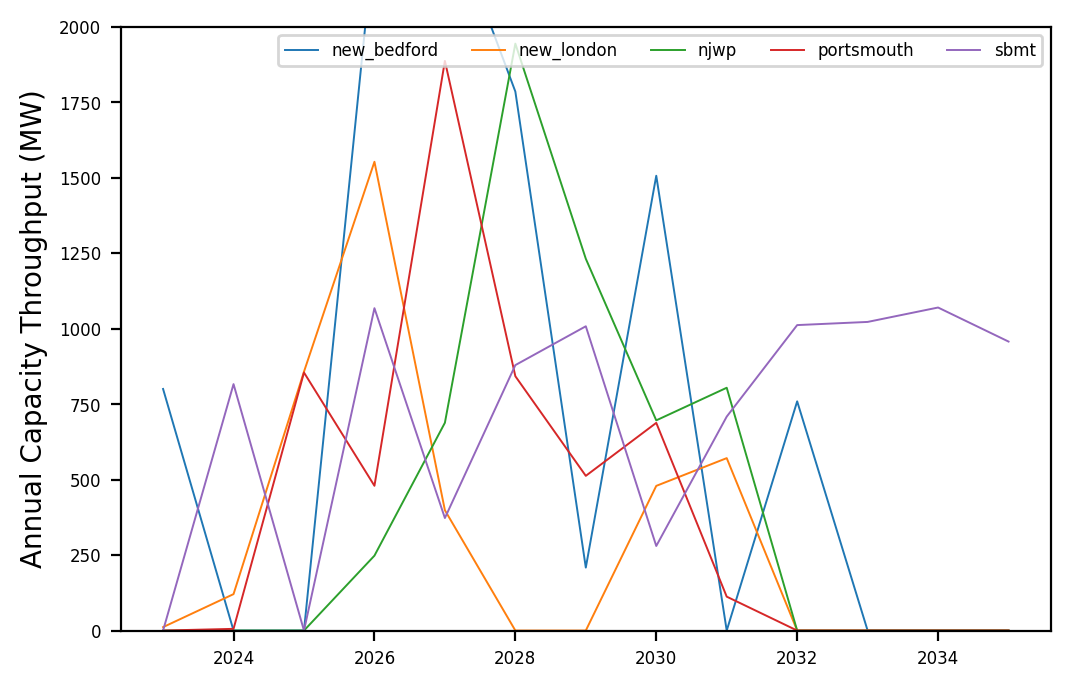

In [56]:
res = []

for _, project in df.iterrows():

    if project["Date Finished"].year == project["Date Started"].year:
        res.append((project["Date Finished"].year, project["port"], project["capacity"]))
        
    else:
        total = project["Date Finished"].date() - project["Date Started"].date()
        for year in np.arange(project["Date Started"].year, project["Date Finished"].year + 1):
            if year == project["Date Started"].year:
                perc = (dt.date(year + 1, 1, 1) - project["Date Started"].date()) / total
                
            elif year == project["Date Finished"].year:
                perc = (project["Date Finished"].date() - dt.date(year, 1, 1)) / total

            else:
                perc = (dt.date(year + 1, 1, 1) - dt.date(year, 1, 1)) / total
        
            res.append((year, project["port"], perc * project["capacity"]))
            
throughput = pd.DataFrame(res, columns=["year", "port", "capacity"]).pivot_table(
    index=["year"],
    columns=["port"],
    aggfunc="sum",
    fill_value=0.
)["capacity"]

fig = plt.figure(figsize=(6, 4), dpi=200)
ax = fig.add_subplot(111)

throughput.plot(ax=ax, lw=0.7)

ax.set_ylim(0, 2000)

ax.set_ylabel("Annual Capacity Throughput (MW)")
ax.set_xlabel("")

plt.xticks(rotation=0, fontsize=6)
plt.yticks(fontsize=6)

ax.legend(fontsize=6, ncol=5)